In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from yahoo_historical import Fetcher

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


c:\users\htadayyon\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\htadayyon\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\htadayyon\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


ModuleNotFoundError: No module named 'keras'

In [ ]:

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
ticker = 'AAPL'
dstart = [2019,1,1]


dataset = Fetcher(ticker, dstart).getHistorical()	
#df = df[['Date','Close']]
dataset.Date = pd.to_datetime(dataset.Date)
dataset.head()

In [80]:
dataset.shape

(529, 7)

In [81]:
dataset.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [82]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,38.505024,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.669640,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.149662,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.069202,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.756794,164101200


In [83]:
dataset.shape

(529, 7)

In [84]:
dataset['chg'] = dataset.Close-dataset.Close.shift(1)
dataset['chg'] = (dataset.Close-dataset.Close.shift(1))>0
dataset['chg'] = dataset['chg'].astype(int)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,chg
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,38.505024,148158800,0
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.669640,365248800,0
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.149662,234428400,1
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.069202,219111200,0
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.756794,164101200,1


In [85]:
dataset = dataset.iloc[1:,:]

In [86]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,chg
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.669640,365248800,0
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.149662,234428400,1
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.069202,219111200,0
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.756794,164101200,1
5,2019-01-09,37.822498,38.632500,37.407501,38.327499,37.380985,180396400,1


In [87]:
dataset.shape

(528, 8)

In [88]:
timestamp = dataset.Date

In [89]:
timestamp.head()

1   2019-01-03
2   2019-01-04
3   2019-01-07
4   2019-01-08
5   2019-01-09
Name: Date, dtype: datetime64[ns]

In [90]:
#remove Time and Name as they are not useful for LSTM
#move Clsoe to last column to make data splitting easier
dataset.drop(['Date','Close','Adj Close'], axis=1, inplace=True)


In [91]:
dataset.head()

,Open,High,Low,Volume,chg
1,35.994999,36.430000,35.500000,365248800,0
2,36.132500,37.137501,35.950001,234428400,1
3,37.174999,37.207500,36.474998,219111200,0
4,37.389999,37.955002,37.130001,164101200,1
5,37.822498,38.632500,37.407501,180396400,1


In [92]:
values = dataset.values

In [93]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [94]:
scaled

array([[0.        , 0.        , 0.        , 0.83841098, 0.        ],
       [0.00127783, 0.00651115, 0.00425051, 0.49544354, 1.        ],
       [0.01096603, 0.00715535, 0.00920939, 0.45528696, 0.        ],
       ...,
       [0.92714083, 0.91422794, 0.92670261, 0.11648824, 0.        ],
       [0.93215926, 0.92922877, 0.9359592 , 0.10155051, 1.        ],
       [0.9419172 , 0.92941286, 0.94795509, 0.07884924, 0.        ]])

In [95]:
# specify the number of lag hours
n_hours = 3
n_features = 5

In [96]:
# frame as supervised learning
reframed0 = series_to_supervised(values, n_hours, 1)
print(reframed0.shape)

(525, 20)


In [97]:
reframed0.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,35.994999,36.430000,35.500000,365248800.0,0.0,36.132500,37.137501,35.950001,234428400.0,1.0,37.174999,37.207500,36.474998,219111200.0,0.0,37.389999,37.955002,37.130001,164101200.0,1.0
4,36.132500,37.137501,35.950001,234428400.0,1.0,37.174999,37.207500,36.474998,219111200.0,0.0,37.389999,37.955002,37.130001,164101200.0,1.0,37.822498,38.632500,37.407501,180396400.0,1.0
5,37.174999,37.207500,36.474998,219111200.0,0.0,37.389999,37.955002,37.130001,164101200.0,1.0,37.822498,38.632500,37.407501,180396400.0,1.0,38.125000,38.492500,37.715000,143122800.0,1.0
6,37.389999,37.955002,37.130001,164101200.0,1.0,37.822498,38.632500,37.407501,180396400.0,1.0,38.125000,38.492500,37.715000,143122800.0,1.0,38.220001,38.424999,37.877499,108092800.0,0.0
7,37.822498,38.632500,37.407501,180396400.0,1.0,38.125000,38.492500,37.715000,143122800.0,1.0,38.220001,38.424999,37.877499,108092800.0,0.0,37.712502,37.817501,37.305000,129756800.0,0.0


In [98]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(525, 20)


In [99]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.000000,0.000000,0.000000,0.838411,0.0,0.001278,0.006511,0.004251,0.495444,1.0,0.010966,0.007155,0.009209,0.455287,0.0,0.012964,0.014035,0.015396,0.311069,1.0
4,0.001278,0.006511,0.004251,0.495444,1.0,0.010966,0.007155,0.009209,0.455287,0.0,0.012964,0.014035,0.015396,0.311069,1.0,0.016983,0.020270,0.018017,0.353790,1.0
5,0.010966,0.007155,0.009209,0.455287,0.0,0.012964,0.014035,0.015396,0.311069,1.0,0.016983,0.020270,0.018017,0.353790,1.0,0.019795,0.018981,0.020922,0.256071,1.0
6,0.012964,0.014035,0.015396,0.311069,1.0,0.016983,0.020270,0.018017,0.353790,1.0,0.019795,0.018981,0.020922,0.256071,1.0,0.020677,0.018360,0.022457,0.164234,0.0
7,0.016983,0.020270,0.018017,0.353790,1.0,0.019795,0.018981,0.020922,0.256071,1.0,0.020677,0.018360,0.022457,0.164234,0.0,0.015961,0.012769,0.017049,0.221030,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.998420,0.992730,0.990932,0.250096,0.0,0.962084,0.971471,0.955889,0.254755,0.0,0.927791,0.923155,0.894588,0.345359,0.0,0.908461,0.910639,0.901388,0.159376,1.0
524,0.962084,0.971471,0.955889,0.254755,0.0,0.927791,0.923155,0.894588,0.345359,0.0,0.908461,0.910639,0.901388,0.159376,1.0,0.926862,0.919198,0.936148,0.099249,1.0
525,0.927791,0.923155,0.894588,0.345359,0.0,0.908461,0.910639,0.901388,0.159376,1.0,0.926862,0.919198,0.936148,0.099249,1.0,0.927141,0.914228,0.926703,0.116488,0.0
526,0.908461,0.910639,0.901388,0.159376,1.0,0.926862,0.919198,0.936148,0.099249,1.0,0.927141,0.914228,0.926703,0.116488,0.0,0.932159,0.929229,0.935959,0.101551,1.0


In [152]:
reframed.drop(['var1(t)','var2(t)','var3(t)','var4(t)'], axis=1, inplace=True)
reframed0.drop(['var1(t)','var2(t)','var3(t)','var4(t)'], axis=1, inplace=True)

In [153]:
reframed.shape
reframed0.shape

(525, 16)

In [166]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
3,0.000000,0.000000,0.000000,0.838411,0.0,0.001278,0.006511,0.004251,0.495444,1.0,0.010966,0.007155,0.009209,0.455287,0.0,1.0
4,0.001278,0.006511,0.004251,0.495444,1.0,0.010966,0.007155,0.009209,0.455287,0.0,0.012964,0.014035,0.015396,0.311069,1.0,1.0
5,0.010966,0.007155,0.009209,0.455287,0.0,0.012964,0.014035,0.015396,0.311069,1.0,0.016983,0.020270,0.018017,0.353790,1.0,1.0
6,0.012964,0.014035,0.015396,0.311069,1.0,0.016983,0.020270,0.018017,0.353790,1.0,0.019795,0.018981,0.020922,0.256071,1.0,0.0
7,0.016983,0.020270,0.018017,0.353790,1.0,0.019795,0.018981,0.020922,0.256071,1.0,0.020677,0.018360,0.022457,0.164234,0.0,0.0


In [167]:
#pd.DataFrame(scaled).head(10)

In [175]:
X = reframed.values
Y = reframed.values
X = X[:,:-1]
Y = Y[:,-1]
print(X.shape)
print(Y.shape)

(525, 15)
(525,)


In [176]:
# split into train and test sets
values = reframed.values
train = values[:400, :]
val = values[400:450, :]
test = values[450:,:]

In [177]:
arr=[1,2,3,4]
print(arr[0:2])
print(arr[2:4])
print(arr[:-1])

[1, 2]
[3, 4]
[1, 2, 3]


In [178]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]

In [179]:
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(400, 15) (400,) (50, 15) (50,) (75, 15) (75,)


In [180]:
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
#val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
#test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
#print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)


In [189]:
from keras.layers import Dropout

def create_baseline():
    model = Sequential()
    model.add(Dense(50, input_dim=train_X.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=20, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 53.13% (5.96%)


In [ ]:
# evaluate baseline model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
6/6 - 0s - loss: 0.6950 - val_loss: 0.6939
Epoch 2/100
6/6 - 0s - loss: 0.6904 - val_loss: 0.6927
Epoch 3/100
6/6 - 0s - loss: 0.6876 - val_loss: 0.6947
Epoch 4/100
6/6 - 0s - loss: 0.6861 - val_loss: 0.6985
Epoch 5/100
6/6 - 0s - loss: 0.6856 - val_loss: 0.7023
Epoch 6/100
6/6 - 0s - loss: 0.6855 - val_loss: 0.7051
Epoch 7/100
6/6 - 0s - loss: 0.6854 - val_loss: 0.7063
Epoch 8/100
6/6 - 0s - loss: 0.6852 - val_loss: 0.7062
Epoch 9/100
6/6 - 0s - loss: 0.6850 - val_loss: 0.7054
Epoch 10/100
6/6 - 0s - loss: 0.6849 - val_loss: 0.7045
Epoch 11/100
6/6 - 0s - loss: 0.6847 - val_loss: 0.7037
Epoch 12/100
6/6 - 0s - loss: 0.6845 - val_loss: 0.7031
Epoch 13/100
6/6 - 0s - loss: 0.6844 - val_loss: 0.7027
Epoch 14/100
6/6 - 0s - loss: 0.6843 - val_loss: 0.7026
Epoch 15/100
6/6 - 0s - loss: 0.6842 - val_loss: 0.7025
Epoch 16/100
6/6 - 0s - loss: 0.6840 - val_loss: 0.7026
Epoch 17/100
6/6 - 0s - loss: 0.6839 - val_loss: 0.7026
Epoch 18/100
6/6 - 0s - loss: 0.6838 - val_loss: 0.7026
E

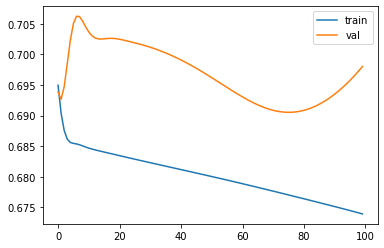

In [145]:
'''
# design network
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.2))
#model.add(LSTM(50, return_sequences = True))
#model.add(Dropout(0.2))
#model.add(LSTM(50))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
'''

In [146]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_X.shape

(75, 15)

In [147]:
reframed.iloc[:, -n_features:-1].columns

Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'], dtype='object')

In [148]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -n_features:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [149]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -n_features:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
import numpy as np
mape = np.mean(100*abs(inv_y-inv_yhat)/inv_y)
smape = np.mean(200*abs(inv_y-inv_yhat)/(inv_y+inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.531
Test MAPE: inf


<ipython-input-149-169f0937b9c3>:9: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(100*abs(inv_y-inv_yhat)/inv_y)


In [150]:
inv_y

array([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0.])

In [151]:
inv_yhat

array([0.76713878, 0.60387641, 0.76322973, 0.75606108, 0.76785105,
       0.60860372, 0.61432391, 0.75040948, 0.59051579, 0.74902636,
       0.7286216 , 0.57010436, 0.59666914, 0.5903753 , 0.74741846,
       0.75531995, 0.75871676, 0.58858472, 0.76154852, 0.602723  ,
       0.62369102, 0.76426029, 0.76754487, 0.62222695, 0.77598906,
       0.76730061, 0.60875261, 0.60468519, 0.59995168, 0.61528331,
       0.61089849, 0.59703004, 0.76486254, 0.77374411, 0.62730819,
       0.6363256 , 0.77536523, 0.61557728, 0.77800667, 0.77207363,
       0.62412024, 0.78119898, 0.61048698, 0.79247934, 0.61067343,
       0.61994976, 0.77641696, 0.61944377, 0.65885437, 0.79828477,
       0.7870636 , 0.79204321, 0.79258436, 0.62621099, 0.78758961,
       0.61717105, 0.63248706, 0.78546393, 0.78264445, 0.63065857,
       0.7938472 , 0.7848649 , 0.63013464, 0.641177  , 0.63941479,
       0.64370006, 0.65070456, 0.65356076, 0.80337846, 0.79829323,
       0.78871965, 0.61786443, 0.63857973, 0.79586756, 0.64363

In [139]:
inv_yhat.shape

(75,)

In [115]:
dataset['Date'] = timestamp
dataset.head()

,Open,High,Low,Volume,chg,Date
1,35.994999,36.430000,35.500000,365248800,0,2019-01-03
2,36.132500,37.137501,35.950001,234428400,1,2019-01-04
3,37.174999,37.207500,36.474998,219111200,0,2019-01-07
4,37.389999,37.955002,37.130001,164101200,1,2019-01-08
5,37.822498,38.632500,37.407501,180396400,1,2019-01-09


In [116]:
tr = dataset.iloc[:450,:]
te = dataset.iloc[450:,]

In [117]:
print(tr.shape)
print(te.shape)

(450, 6)
(78, 6)


In [118]:
te.Date[4:].head()

455   2020-10-21
456   2020-10-22
457   2020-10-23
458   2020-10-26
459   2020-10-27
Name: Date, dtype: datetime64[ns]

In [119]:
te.Date.head()

451   2020-10-15
452   2020-10-16
453   2020-10-19
454   2020-10-20
455   2020-10-21
Name: Date, dtype: datetime64[ns]

In [120]:
te.Date.tail()

524   2021-02-01
525   2021-02-02
526   2021-02-03
527   2021-02-04
528   2021-02-05
Name: Date, dtype: datetime64[ns]

In [121]:
from pandas.tseries.offsets import BDay
dates = te.Date[4:]
dates = dates.append(te.Date.tail(1) + BDay(1))
dates.tail()

525   2021-02-02
526   2021-02-03
527   2021-02-04
528   2021-02-05
528   2021-02-08
Name: Date, dtype: datetime64[ns]

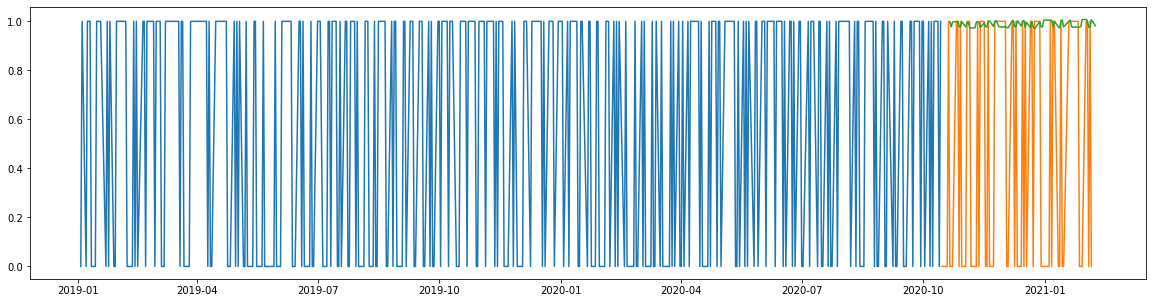

In [122]:
plt.figure(figsize=(20,5))
plt.plot(tr.Date, tr.chg)
plt.plot(te.Date, te.chg)
plt.plot(dates, inv_yhat)

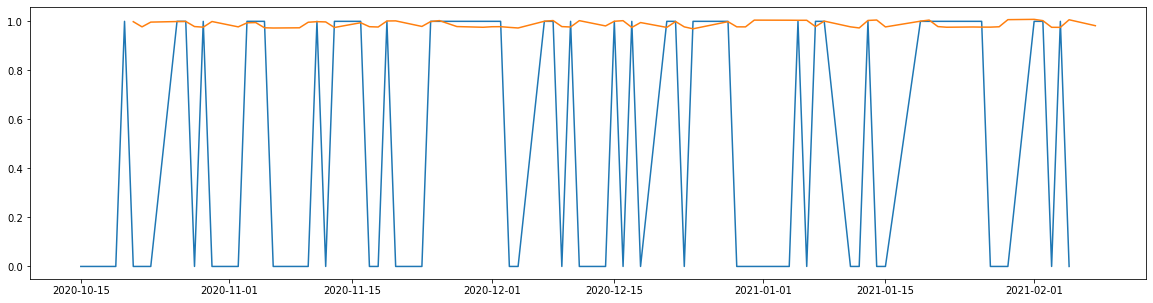

In [123]:
plt.figure(figsize=(20,5))
plt.plot(te.Date, te.chg)
plt.plot(dates, inv_yhat)

In [124]:
df_pred = pd.DataFrame(dates, columns = ['Date']).reset_index(drop=True)
df_pred['pred'] = inv_yhat
df_pred.head()

,Date,pred
0,2020-10-21,0.998585
1,2020-10-22,0.977520
2,2020-10-23,0.996876
3,2020-10-26,0.999178
4,2020-10-27,0.999579


In [125]:
merged_data = te.merge(df_pred, on = 'Date')

In [126]:
merged_data

,Open,High,Low,Volume,chg,Date,pred
0,116.669998,118.709999,116.449997,89946000,0,2020-10-21,0.998585
1,117.449997,118.040001,114.589996,101988000,0,2020-10-22,0.977520
2,116.389999,116.550003,114.279999,82572600,0,2020-10-23,0.996876
3,114.010002,116.550003,112.879997,111850700,1,2020-10-26,0.999178
4,115.489998,117.279999,114.540001,92276800,1,2020-10-27,0.999579
...,...,...,...,...,...,...,...
69,133.750000,135.380005,130.929993,106239800,1,2021-02-01,1.008106
70,135.729996,136.309998,134.610001,83305400,1,2021-02-02,1.002833
71,135.759995,135.770004,133.610001,89880900,0,2021-02-03,0.975676
72,136.300003,137.399994,134.589996,84183100,1,2021-02-04,0.975487


In [76]:
merged_data['dir'] = merged_data['chg']>0
merged_data['dir'] =  merged_data['dir'].astype(int)
merged_data.head()

,Open,High,Low,Volume,chg,Date,pred,dir
0,116.669998,118.709999,116.449997,89946000,-0.639999,2020-10-21,-0.178696,0
1,117.449997,118.040001,114.589996,101988000,-1.120003,2020-10-22,-0.285148,0
2,116.389999,116.550003,114.279999,82572600,-0.709999,2020-10-23,-0.211624,0
3,114.010002,116.550003,112.879997,111850700,0.010002,2020-10-26,0.093250,1
4,115.489998,117.279999,114.540001,92276800,1.549995,2020-10-27,-0.131972,1


In [77]:

merged_data['dir_pred'] = merged_data['pred']>0
merged_data['dir_pred'] =  merged_data['dir_pred'].astype(int)
merged_data.head(20)

,Open,High,Low,Volume,chg,Date,pred,dir,dir_pred
0,116.669998,118.709999,116.449997,89946000,-0.639999,2020-10-21,-0.178696,0,0
1,117.449997,118.040001,114.589996,101988000,-1.120003,2020-10-22,-0.285148,0,0
2,116.389999,116.550003,114.279999,82572600,-0.709999,2020-10-23,-0.211624,0,0
3,114.010002,116.550003,112.879997,111850700,0.010002,2020-10-26,0.093250,1,1
4,115.489998,117.279999,114.540001,92276800,1.549995,2020-10-27,-0.131972,1,0
5,115.050003,115.430000,111.099998,143937800,-5.400001,2020-10-28,-0.079271,0,0
6,112.370003,116.930000,112.199997,146129200,4.120003,2020-10-29,0.020209,1,1
7,111.059998,111.989998,107.720001,190272600,-6.459999,2020-10-30,0.136017,0,1
8,109.110001,110.680000,107.320000,122866900,-0.090004,2020-11-02,-0.016394,0,0
9,109.660004,111.489998,108.730003,107624400,1.670005,2020-11-03,-0.150601,1,0


In [78]:
match = merged_data.dir==merged_data.dir_pred
match.sum()/len(match)

0.4864864864864865